In [6]:
# imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Data Preparation

In [7]:
# stopwords
nltk.download('stopwords')
nltk.download('punkt')

# word normalizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# constants
conn = sqlite3.connect('StaterData.db')
query = "SELECT * FROM 'mortgage complaints'"
dtypes = {'Date received': str,
          'Product': "category",
          'Sub-product': "category",
          'Issue': "category",
          'Sub-issue':"category",
          'Consumer complaint narrative':str,
          'Company public response':str,
          'Company':"category",
          'State':"category",
          'ZIP code':str,
          'Tags':"category",
          'Consumer consent provided?':str,
          'Submitted via':"category",
          'Date sent to company':str,
          'Company response to consumer':str,
          'Timely response?':str,
          'Consumer disputed?':str,
          'Complaint ID':int
          }

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
data = pd.read_sql_query(query, conn, dtype=dtypes)
print("data loaded")
df = data[['Consumer complaint narrative', 'Issue']].copy()

data loaded


In [9]:
# remove stopwords and return the text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([token for token in nltk.word_tokenize(text) if token.lower() not in stop_words])

def clean_text(text):
    # Remove numerical values
    text = re.sub(r'\d+', '', text)

    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Remove links and URLs
    text = re.sub(r'http\S+', '', text)

    # Remove leading/trailing white space and convert to lowercase
    text = text.strip().lower()

    return text

# lemmitize the word based on its part of speech (POS) tag
def lemmatize_word(word, tag, lemmatizer):
    # Map POS tag to WordNet POS tag
    if tag.startswith('J'):
        # Adjective
        wn_tag = 'a'
    elif tag.startswith('V'):
        # Verb
        wn_tag = 'v'
    elif tag.startswith('N'):
        # Noun
        wn_tag = 'n'
    elif tag.startswith('R'):
        # Adverb
        wn_tag = 'r'
    else:
        wn_tag = None

    # Lemmatize the word
    if wn_tag:
        lemma = lemmatizer.lemmatize(word, wn_tag)
    else:
        lemma = word

    return lemma

# lemmatize the sentence that is already tokenized
def lemmatize_sentence(lemmatizer, tokens):
    # Part-of-speech (POS) tag each word
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each word based on its POS tag
    lemmas = [lemmatize_word(word, tag, lemmatizer) for word, tag in pos_tags]

    # Join the lemmas back into a sentence
    lemmatized_sentence = ' '.join(lemmas)

    return lemmatized_sentence

def remove_non_alphabetica_char_and_x(text):
    # remove non alphabetical characters
    alphabetical_text = [re.sub('[^a-zA-Z]+', '', word) for word in text]

    # remove x from the text with regex
    alphabetical_text = [word for word in alphabetical_text if not re.match('^x+$', word)]
    return ' '.join(alphabetical_text)

def clean_complaint(complaint):
        lemmatizer = WordNetLemmatizer()
        cleaned_complaint = remove_stopwords(complaint)
        cleaned_complaint = clean_text(cleaned_complaint)
        # Tokenize the sentence into words
        tokens = nltk.word_tokenize(cleaned_complaint)
        cleaned_complaint = lemmatize_sentence(lemmatizer, tokens)
        tokenized_complaint = word_tokenize(cleaned_complaint)
        cleaned_complaint = remove_non_alphabetica_char_and_x(tokenized_complaint)
        return cleaned_complaint
    
# one for loop in batches to, remove stopwords, clean text, lemmatize, tokenize, and remove x or non alphabetic characters
def clean_complaints(df_column):
    cleaned_complaints_df = pd.DataFrame(columns=[df_column.name])
    batch_size = 10000
    batch_index = 0
    number_of_batches = math.ceil(len(df_column) / batch_size)
    # number_of_batches = 2
    while batch_index < number_of_batches:
        print(f"batch {batch_index+1} of {number_of_batches}")
        cleaned_complaints = []
        complaints = df_column[batch_index * batch_size: (batch_index + 1) * batch_size]
        for complaint in complaints:
            complaint = clean_complaint(complaint)
            cleaned_complaints.append(complaint)
        clean_complaints_df = pd.DataFrame(cleaned_complaints, columns=[df_column.name])
        cleaned_complaints_df = pd.concat([cleaned_complaints_df, clean_complaints_df], axis=0)
        batch_index += 1
        del complaints
        del complaint
        del cleaned_complaints
        del clean_complaints_df
    return cleaned_complaints_df[df_column.name]

In [10]:
print("cleaning text")
df['Cleaned consumer complaint'] = clean_complaints(df['Consumer complaint narrative']).reset_index(drop=True)

cleaning text
batch 1 of 11
batch 2 of 11
batch 3 of 11
batch 4 of 11
batch 5 of 11
batch 6 of 11
batch 7 of 11
batch 8 of 11
batch 9 of 11
batch 10 of 11
batch 11 of 11


# Modelling

In [11]:
# get the independent and dependent variables as x and y
x = df['Cleaned consumer complaint']
y = df['Issue']
# get all categories of y for the results
cat_issue = y.cat.categories

print("splitting data into train and test sets")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

splitting data into train and test sets


In [12]:
# vectorize text of x
print("vectorizing text")
vectorizer = TfidfVectorizer(
    stop_words="english",
    token_pattern=r'\b[a-zA-Z]+\b',
    analyzer="word",
    use_idf=True,
    smooth_idf=True,
    norm=None,
    tokenizer=None,
    preprocessor=None
)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

vectorizing text


saga and sag are solvers to use for multinomial logistic regression. Both supports multinomial logistic regressions. In this case, the sag will be used as it is better in performance. However, saga is a variant of sag and supports more penalties than sag.
more information: https://scikit-learn.org/stable/modules/linear_model.html#solvers

In [15]:
# multinomial logistic regression
print("creating model")
logregression = LogisticRegression(n_jobs=4, solver='saga', multi_class='multinomial', max_iter=10000)

creating model


In [ ]:
print("fitting model")
logregression.fit(X_train, y_train)

print("predicting test data")
y_pred = logregression.predict(X_test)

fitting model


In [ ]:
print(f"score:{logregression.score(X_test, y_test)}")
print(f"accuracy:{accuracy_score(y_test, y_pred)}")
print(f"f1 score:{f1_score(y_test, y_pred, average='weighted')}")

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=cat_issue, index=cat_issue)
cm = (cm.transpose()/cm.sum(axis=1)).transpose()

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True)
plt.show()

In [22]:
# # Create the GridSearchCV object
# grid_search = GridSearchCV(logregression, param_grid=params, cv=5)
# grid_search.fit(x, y)
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

In [23]:
print(classification_report(y_test, y_pred, target_names=cat_issue))

In [24]:
print("testing model with custom text")
new_complaint = "My mortgage was sold to Roundpoint company in XX/XX/2023. I got a letter in XXXX from my prior lender, XXXX XXXX stating this was to occur and the next payment to be made would go to Roundpoint. But this is false. The information in the letter is not true. I think it is a mistake of yours"
new_complaint_vectorized = vectorizer.transform([new_complaint])
issue_pred = logregression.predict(new_complaint_vectorized)
print('Predicted issue:', issue_pred[0])

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.626390161826464

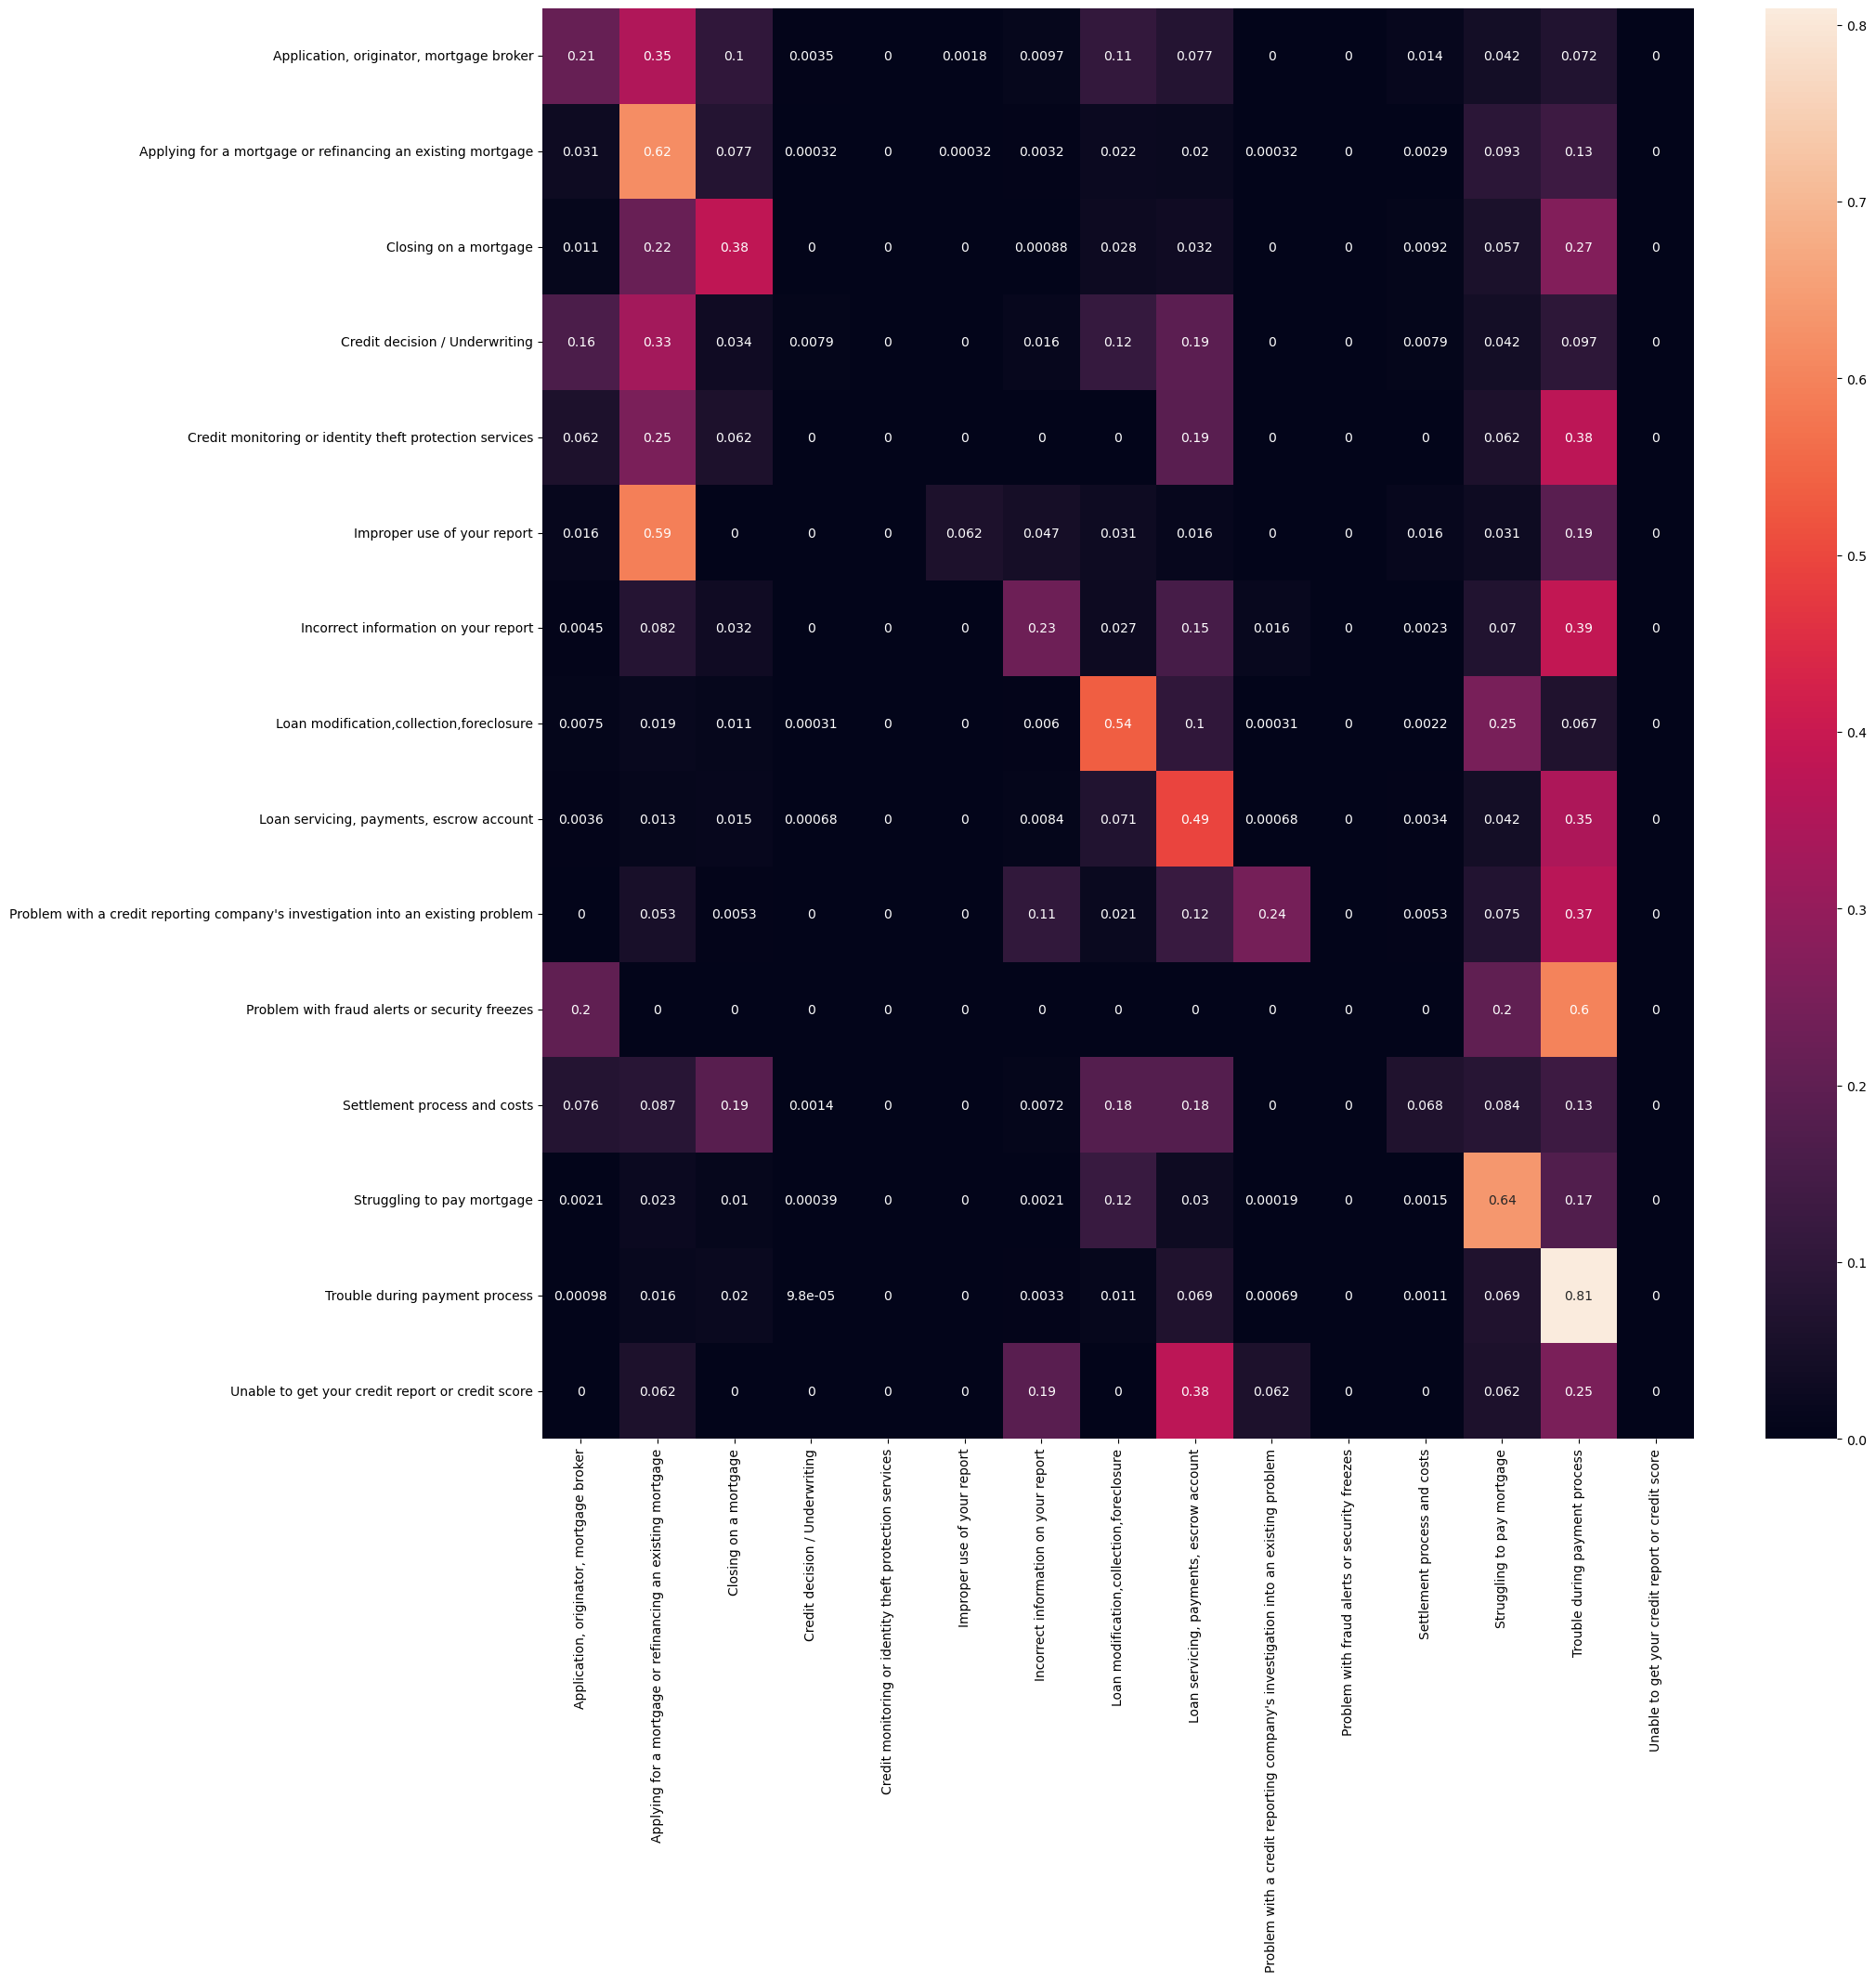

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.45      0.21      0.29      1139
                     Applying for a mortgage or refinancing an existing mortgage       0.55      0.62      0.58      3125
                                                           Closing on a mortgage       0.50      0.38      0.43      2281
                                                  Credit decision / Underwriting       0.19      0.01      0.02       381
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        16
                                                     Improper use of your report       0.57      0.06      0.11        64
                                            Incorrect information on your report       0.38      0.23      0.29       440
                       

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
